### Импорты

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Препроцессинг

In [115]:
flights = pd.read_csv('datasets/flights.csv', low_memory=False)
airports = pd.read_csv('datasets/airports.csv', low_memory=False)
airlines = pd.read_csv('datasets/airlines.csv', low_memory=False)

In [116]:
valid_airports = airports["IATA_CODE"].unique()
flights = flights[flights["ORIGIN_AIRPORT"].apply(lambda x : x in valid_airports)] # убираем строки, где некоррентный аэропорт
flights = flights.dropna(subset=["DEPARTURE_DELAY"])  # убираем строчки без данных о задержке
flights[flights['DEPARTURE_DELAY'] < 0] = 0  # если задержка меньше нуля - то её нет


## Первая гипотеза

Рассмотрим задержки по аэропортам

In [117]:
delay_by_airport = flights.groupby(["ORIGIN_AIRPORT"])["DEPARTURE_DELAY"].median()
delay_by_airport_last_10per = delay_by_airport.loc[delay_by_airport.sort_values()[-int(delay_by_airport.shape[0]*0.1):].index]
delay_by_airport_first_90per = delay_by_airport.loc[delay_by_airport.sort_values()[0:int(delay_by_airport.shape[0]*0.9):].index]

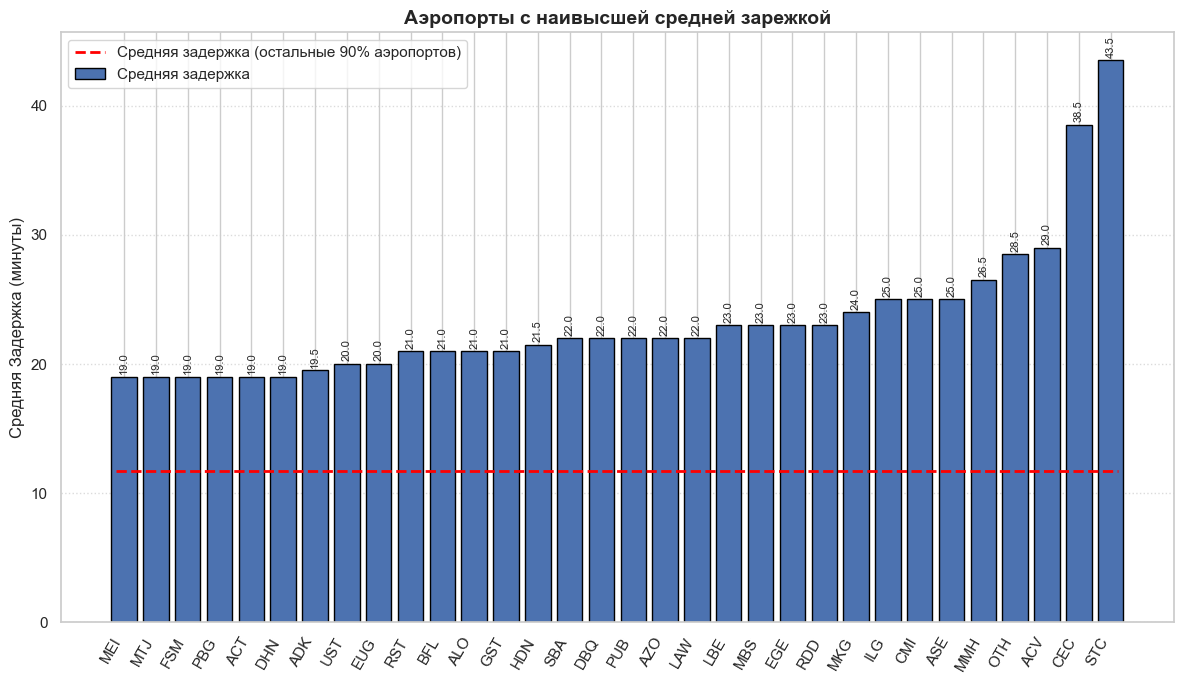

In [118]:
plt.figure(figsize=(12, 7))

bars = plt.bar(
    delay_by_airport_last_10per.index,
    delay_by_airport_last_10per,
    label="Средняя задержка",
    color="#4C72B0",
    edgecolor="black",
    width=0.8
)

plt.axhline(
    delay_by_airport_first_90per.mean(),
    xmin=0.05,
    xmax=0.95,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Средняя задержка (остальные 90% аэропортов)"
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.2,
        f'{height:.1f}',
        ha='center',
        va='bottom',
        fontsize=8,
        rotation=90
    )

plt.xticks(rotation=60, ha='right')
plt.ylabel("Средняя Задержка (минуты)")
plt.title("Аэропорты с наивысшей средней зарежкой", fontsize=14, weight='bold')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

Здесь мы наблюдаем ситуацию, когда аэропорты, показанные на графике выше, систематически не справляются с пассажиропотоком: их средняя задержка значительно превышает среднюю задержку 90% остальных аэропортов страны. Необходимо расширить возможности этих аэропортов — например, нанять больше персонала или открыть дополнительные линии.

## Вторая гипотеза

Рассмотрим авиакомпании по задержкам

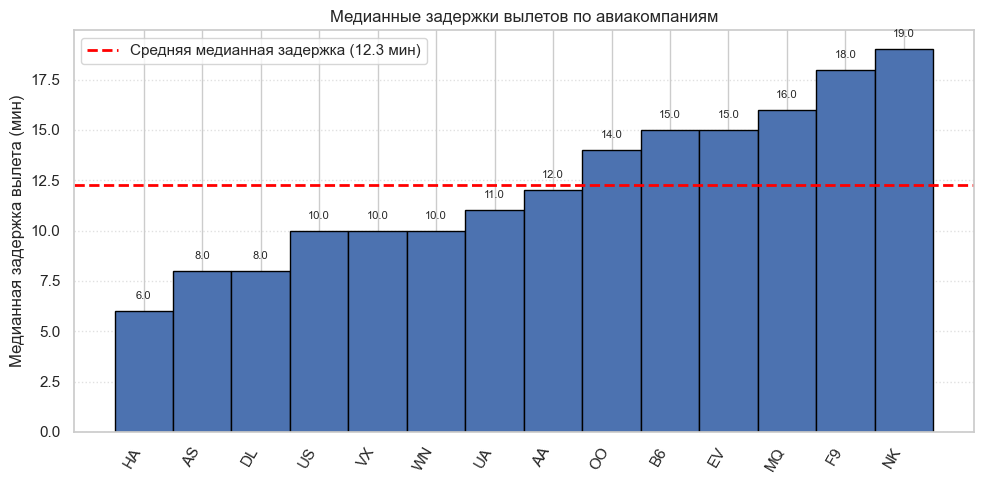

In [124]:
import matplotlib.pyplot as plt

delay_by_line = flights.groupby("AIRLINE")["DEPARTURE_DELAY"].median().sort_values()

plt.figure(figsize=(10, 5))
bars = plt.bar(delay_by_line.index, delay_by_line, width=1, edgecolor="black")

mean_delay = delay_by_line.values.mean()
plt.axhline(mean_delay, color="red", lw=2, linestyle="--", label=f"Средняя медианная задержка ({mean_delay:.1f} мин)")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{height:.1f}", ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=60, ha='right')
plt.ylabel("Медианная задержка вылета (мин)")
plt.title("Медианные задержки вылетов по авиакомпаниям")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()


Нам следует внимательно проанализировать, почему у таких авиакомпаний, как JetBlue Airways, SkyWest Airlines Inc., American Eagle Airlines Inc., Atlantic Southeast Airlines, Spirit Air Lines и Frontier Airlines Inc., регулярно наблюдаются значительные задержки рейсов. Это может быть связано с целым рядом факторов — от внутренних проблем в организации логистики и нехватки персонала до перегруженности маршрутов, неэффективного планирования расписания или технических неисправностей. Важно выявить причины этих задержек, чтобы предложить меры по оптимизации работы и снижению уровня задержек.

## Третья гипотеза

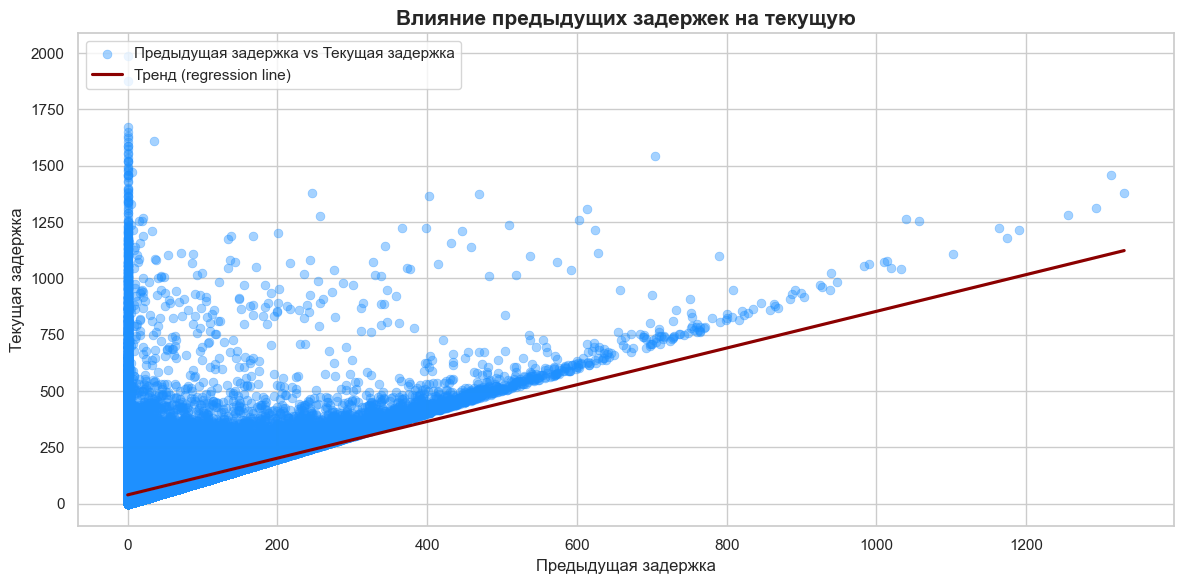

In [125]:
sns.set(style="whitegrid", context="notebook")

plt.figure(figsize=(12, 6))

sns.scatterplot(
    x='LATE_AIRCRAFT_DELAY',
    y='DEPARTURE_DELAY',
    data=flights,
    alpha=0.4,
    s=40,
    color='dodgerblue',
    edgecolor=None,
    label="Предыдущая задержка vs Текущая задержка"
)

sns.regplot(
    x='LATE_AIRCRAFT_DELAY',
    y='DEPARTURE_DELAY',
    data=flights,
    scatter=False,
    color='darkred',
    label="Тренд (regression line)"
)

plt.title('Влияние предыдущих задержек на текущую', fontsize=15, weight='bold')
plt.xlabel('Предыдущая задержка', fontsize=12)
plt.ylabel('Текущая задержка', fontsize=12)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


Одной из ключевых причин цепных задержек является слишком плотное расписание вылетов. Если один рейс опаздывает, это автоматически влияет на следующие — особенно если используются одни и те же самолёты или экипажи. Чтобы снизить эффект "домино", необходимо увеличить временной буфер между вылетами.

## Четвертый пункт

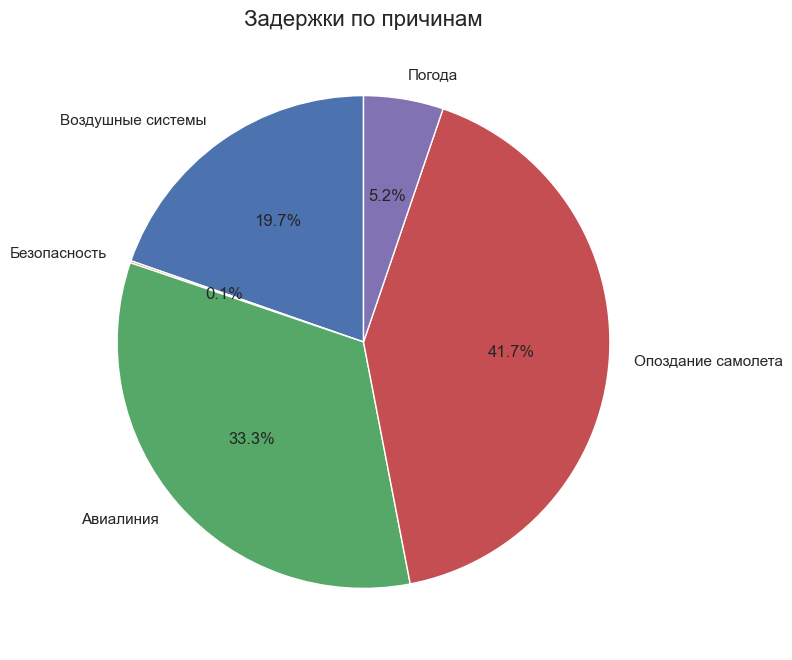

In [126]:
delay_causes = flights[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']].sum()
labels = ['Воздушные системы', 'Безопасность', 'Авиалиния', 'Опоздание самолета', 'Погода']
plt.figure(figsize=(8, 8))
plt.pie(delay_causes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Задержки по причинам', fontsize=16)
plt.show()

Данный график показывает важность предыдущих пунктов

## Пятая гипотеза

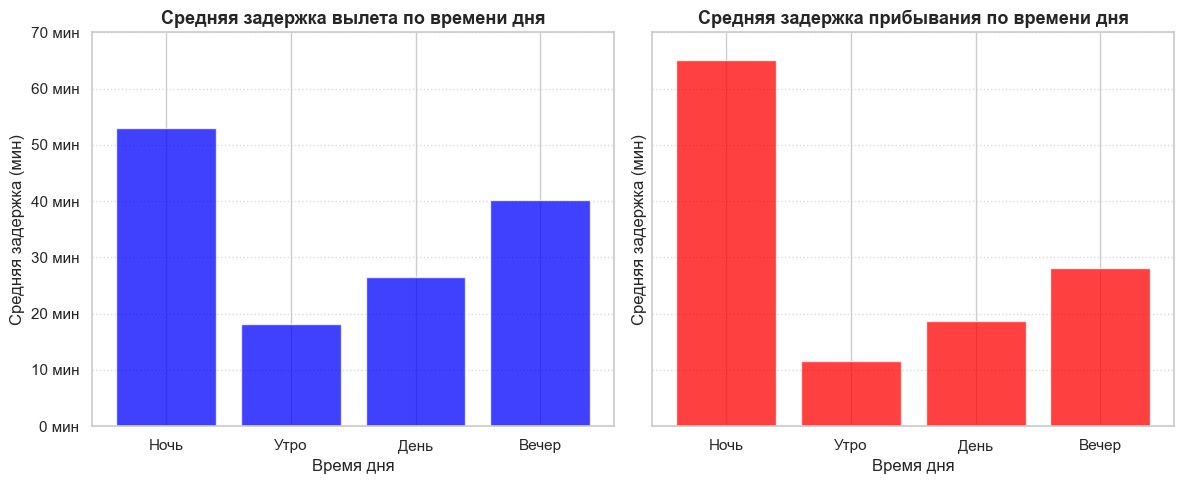

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

flights["TIME_OF_DAY_DEP"] = pd.cut(
    flights['DEPARTURE_TIME'] / 100,
    bins=[0, 6, 12, 18, 24],
    labels=["Ночь", "Утро", "День", "Вечер"],
    right=False
)

flights["TIME_OF_DAY_ARR"] = pd.cut(
    flights['ARRIVAL_TIME'] / 100,
    bins=[0, 6, 12, 18, 24],
    labels=["Ночь", "Утро", "День", "Вечер"],
    right=False
)

mean_dep_delay = flights.groupby('TIME_OF_DAY_DEP', observed=True)['DEPARTURE_DELAY'].mean()
mean_arr_delay = flights.groupby('TIME_OF_DAY_ARR', observed=True)['ARRIVAL_DELAY'].mean()

def plot_delay_bar(ax, data, title, color='blue'):
    ax.bar(data.index, data, alpha=0.75, color=color)
    ax.set_title(title, fontsize=13, weight='bold')
    ax.set_xlabel('Время дня')
    ax.set_ylabel('Средняя задержка (мин)')
    y_ticks = range(0, int(data.max()) + 10, 10)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{i} мин" for i in y_ticks])
    ax.grid(axis='y', linestyle=':', alpha=0.7)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

plot_delay_bar(ax1, mean_dep_delay, 'Средняя задержка вылета по времени дня')
plot_delay_bar(ax2, mean_arr_delay, 'Средняя задержка прибывания по времени дня', color='red')

plt.tight_layout()
plt.show()


Как мы можем наблюдать, наибольшие задержки происходят в вечернее и ночное время.

Возможная причина:
В это время может быть недостаточно сотрудников, работающих в ночную смену — как на стороне аэропортов, так и у авиакомпаний. Это может приводить к замедленной обработке рейсов, задержкам при обслуживании самолётов, регистрации пассажиров и прочим организационным сбоям.

Возможное решение:
Увеличить количество сотрудников, работающих в ночное и вечернее время. Это касается как персонала аэропортов (диспетчеры, службы обслуживания, багажные службы), так и сотрудников авиакомпаний (экипажи, технический персонал). Также стоит пересмотреть нагрузку на ночные часы и, при необходимости, перераспределить расписание рейсов более равномерно в течение суток.